In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

sys.path.append('/home/jmdeloui/STL_dev/STL_main')

from STL_Healpix_Kernel_Torch import STL_Healpix_Kernel_Torch as DataClass

In [2]:
nside=32

im=np.random.rand(12*nside**2)

data=DataClass(im)

# test wavelet computation

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


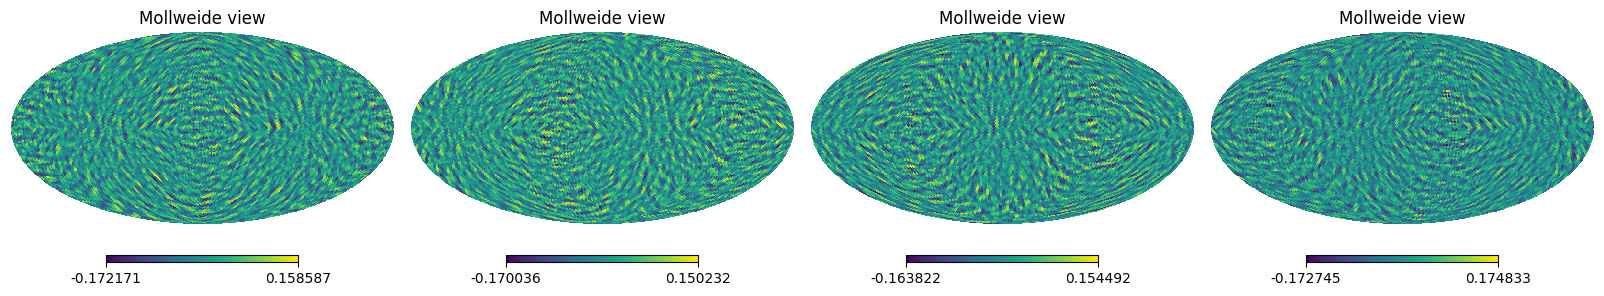

In [3]:
w_op=data.get_wavelet_op()

w_data = w_op.apply(data,0).array

plt.figure(figsize=(16,6))
for k in range(4):
    hp.mollview(w_data[k].cpu().numpy(),nest=True,hold=False,sub=(1,4,1+k))

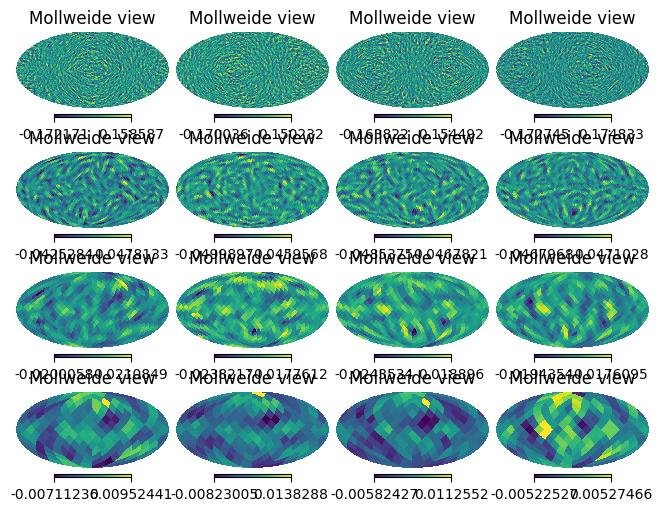

In [4]:
l_data=DataClass(im)
for j in range(4):
    w_data = w_op.apply(l_data,j).array
    for k in range(4):
        hp.mollview(w_data[k].cpu().numpy(),nest=True,hold=False,sub=(4,4,1+k+4*j))
    
    #l_data=w_op.apply_smooth(l_data,copy=True)
    l_data=l_data.downsample(j+1)

In [5]:
from ST_Operator import ST_Operator as STO

l_data=DataClass(im)

st_op=STO(l_data)

st_data = st_op.apply(l_data)

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jmdeloui/STL_dev/STL_main/ST_Statistics.py:494: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


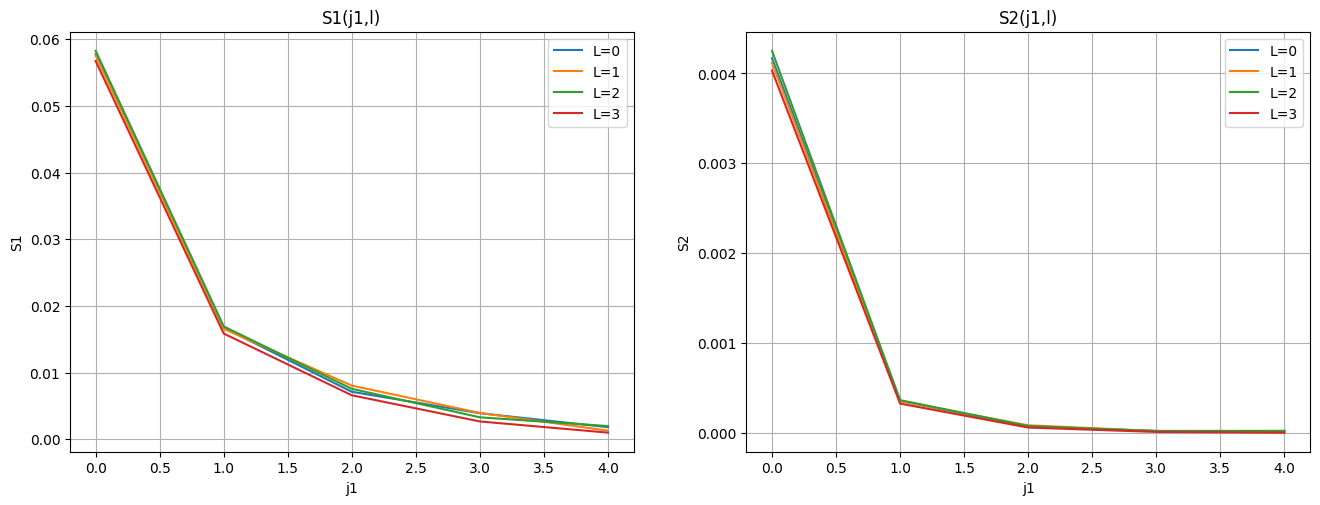

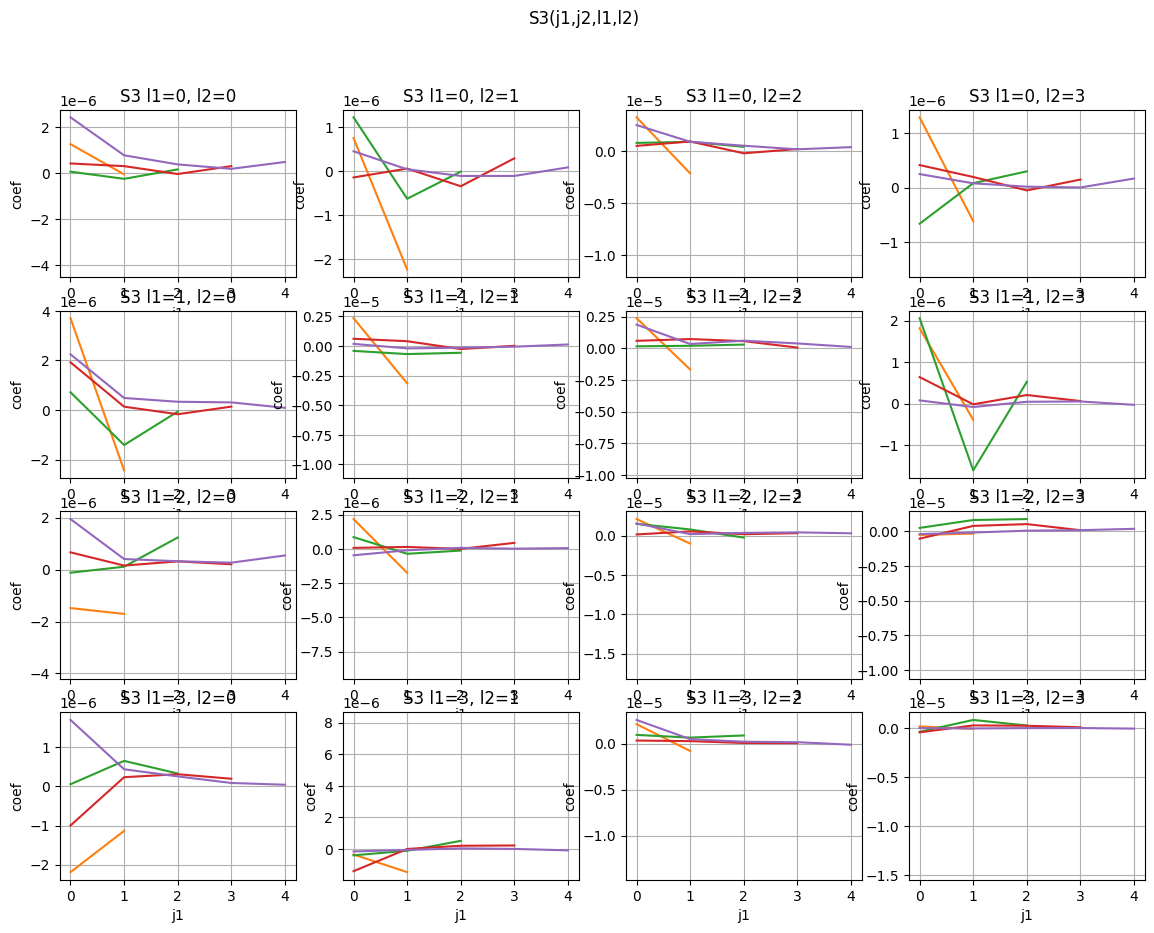

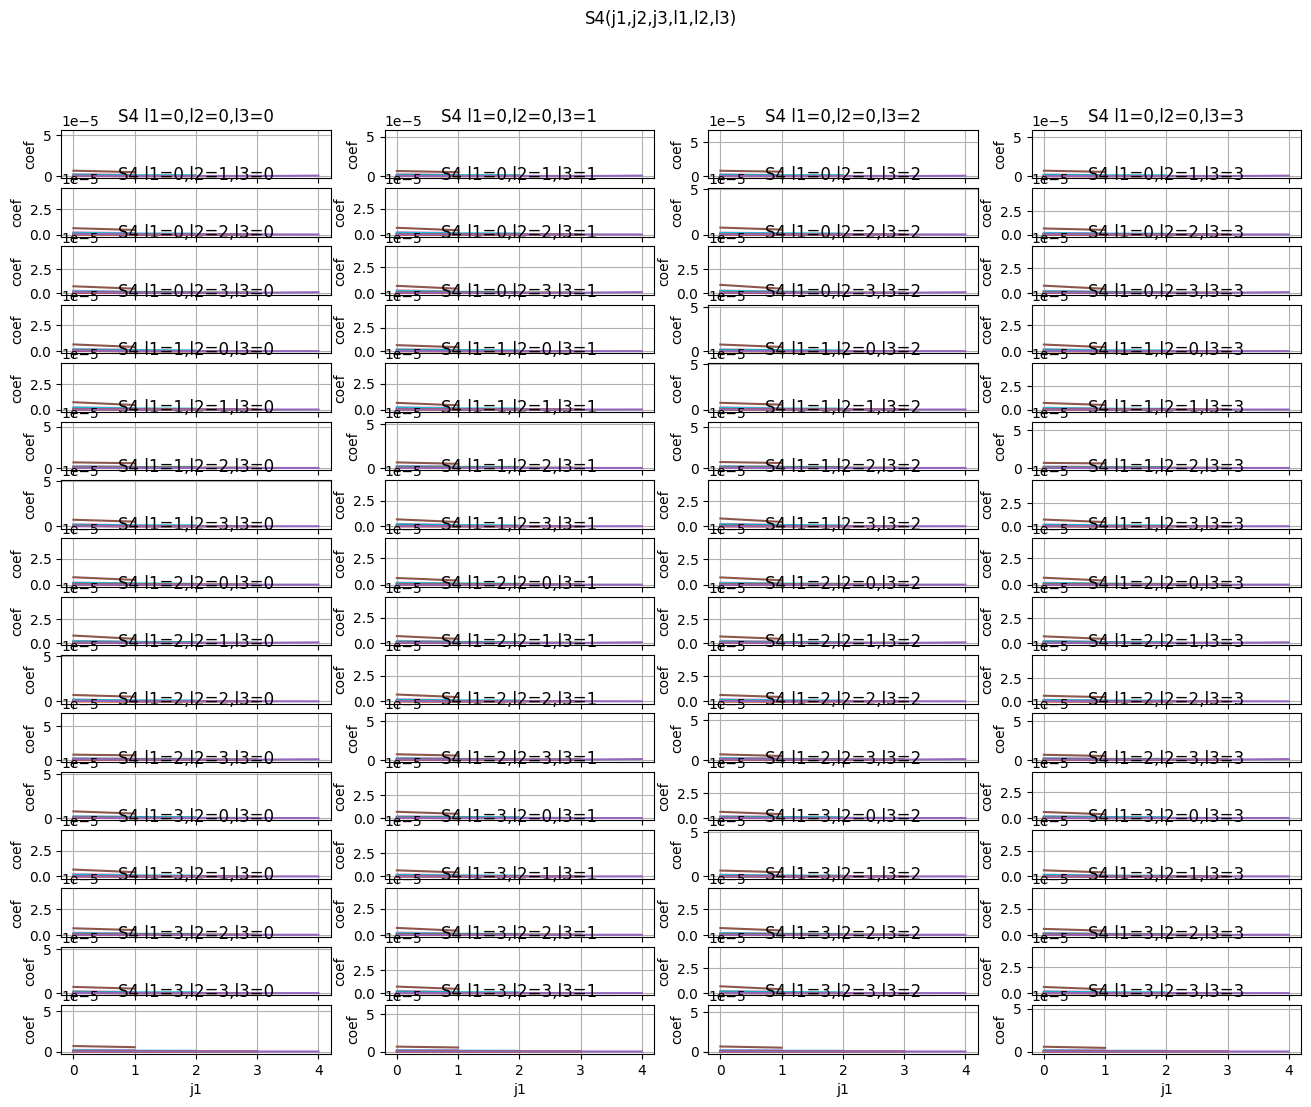

In [6]:
st_data.plot_coeff()

# do synthesis

In [7]:
st_data = st_op.apply(l_data)
st_data_norm = st_op.apply(l_data,norm='store_ref')

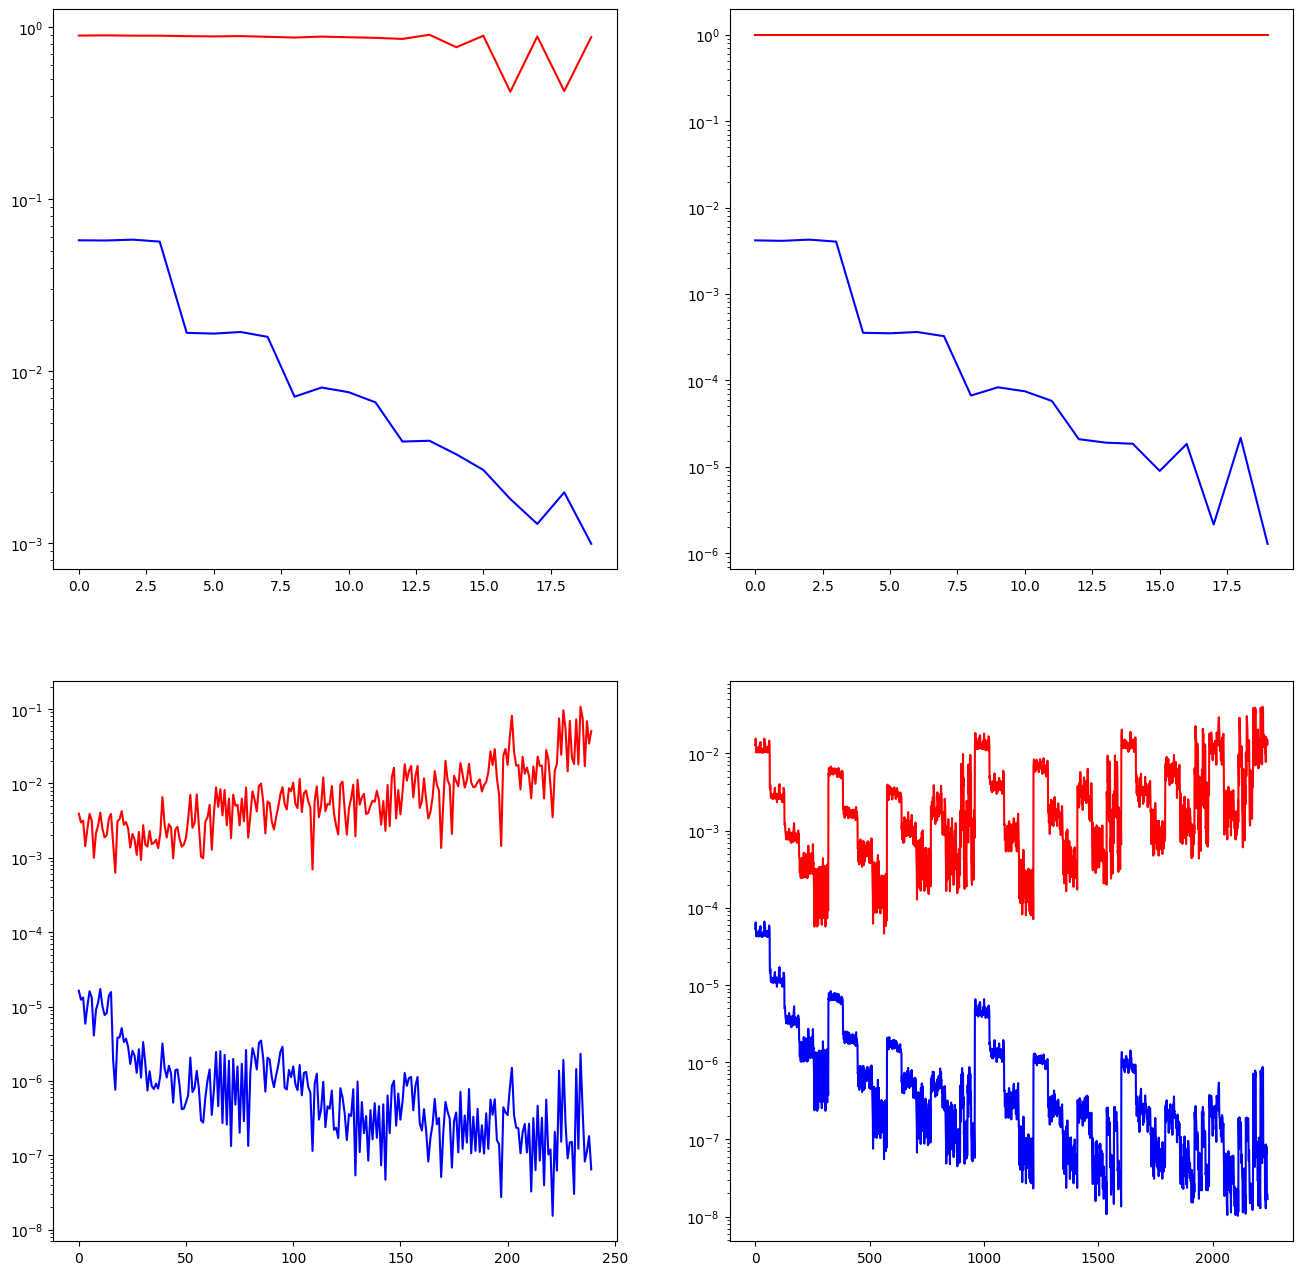

In [8]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')
def r_nan(x):
    return x[np.isfinite(x)]
plt.subplot(2,2,3)
plt.plot(r_nan(st_data.S3.abs().cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S3.abs().cpu().numpy().flatten()),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(r_nan(st_data.S4.cpu().numpy().flatten()),color='b')
plt.plot(r_nan(st_data_norm.S4.cpu().numpy().flatten()),color='r')
plt.yscale('log')

# do synthesis

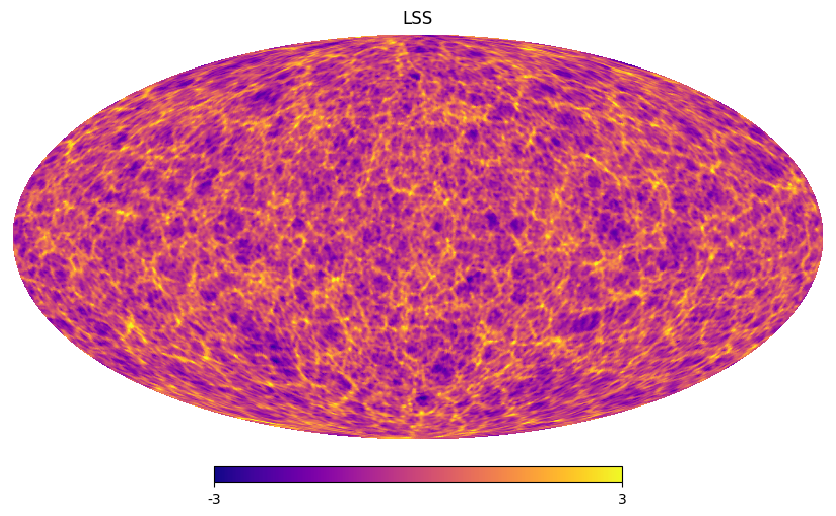

In [13]:
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=128 healpix map
l_nside=128
nside=256
im = np.load('/home/jmdeloui/NOTEBOOK/TestAndValidation/target_map_lss.npy')
xsize,ysize=im.shape

# Define the new row and column to be added to prepare the interpolation
new_row = im[0:1,:]  # A new row with N elements (the other longitude)
new_column = np.concatenate([im[:,0:1],im[-2:-1,0:1]],0)  # A new column with N+1 elements to add previous latitude

# Add the new row to the array
im = np.vstack([im, new_row])

# Add the new column to the array with the new row

im = np.hstack([im, new_column])

# Create a grid of coordinates corresponding to the array indices
x = np.linspace(0, im.shape[0]-1, im.shape[0])
y = np.linspace(0, im.shape[1]-1, im.shape[1])

# Create an interpolator
interpolator = RegularGridInterpolator((x, y), im)

# List of healpix coordinate to interpol
colatitude,longitude = hp.pix2ang(l_nside,np.arange(12*l_nside**2),nest=True)
coords = np.concatenate([colatitude/np.pi*xsize,longitude/(2*np.pi)*ysize],0).reshape(2,colatitude.shape[0]).T

# Perform the interpolation
heal_im = interpolator(coords)

#reduce the final map to the expected resolution
if nside>128:
    th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
    heal_im=hp.get_interp_val(heal_im,th,ph,nest=True)
else:
    heal_im=np.mean(heal_im.reshape(12*nside**2,(l_nside//nside)**2),1)
hp.mollview(heal_im,cmap='plasma',nest=True,title='LSS',min=-3,max=3)

# free memory
del coords
del interpolator
del colatitude
del longitude

In [ ]:
np.save('/hoTest_Heal_LSS.npy',heal_im)